# Face detection model to Classify mask

<font size = 4><b> Steps to take </b><br><br></font>
<font color = "darkblue">1) Data preprocessing<br>
2) Training of data<br>
3) Testing model on Webcam <br></font>



In [1]:
import cv2
import matplotlib.pyplot as plt
import lxml.etree
import xmltodict
import os
from PIL import Image
import numpy as np
import collections
import math

### Read images using cv2 library


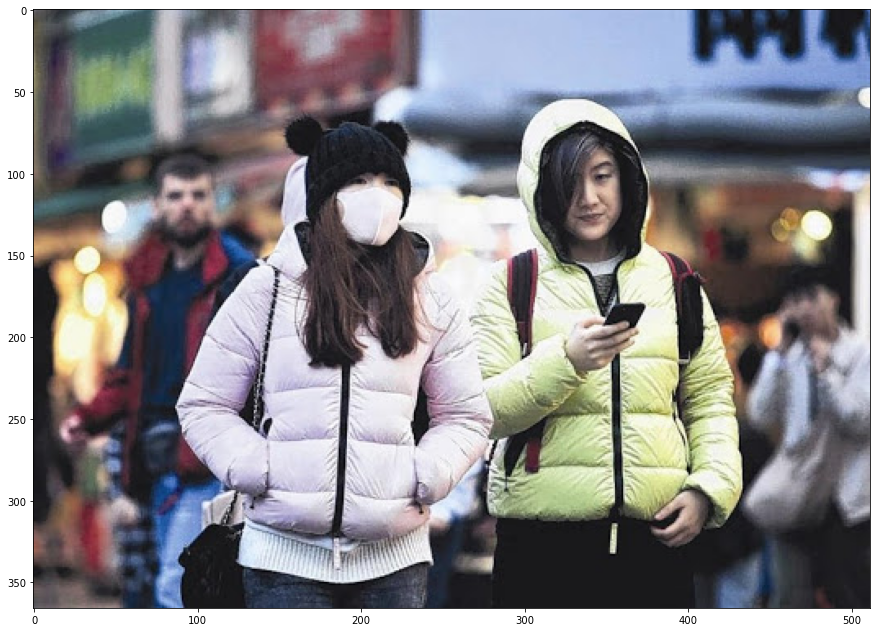

In [2]:
imgDirectory = r"C:/Users/Oliver/Downloads/Machine learning project/images/"
annoDirectory = r"C:/Users/Oliver/Downloads/Machine learning project/annotations/"
img = cv2.imread(imgDirectory+"maksssksksss0.png")

#OpenCV uses BGR as its default colour order for images, matplotlib uses RGB. When you display an image loaded with 
#OpenCv in matplotlib the channels will be back to front. 
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(15,15))
plt.imshow(out_img)

# 1) Data preprocessing
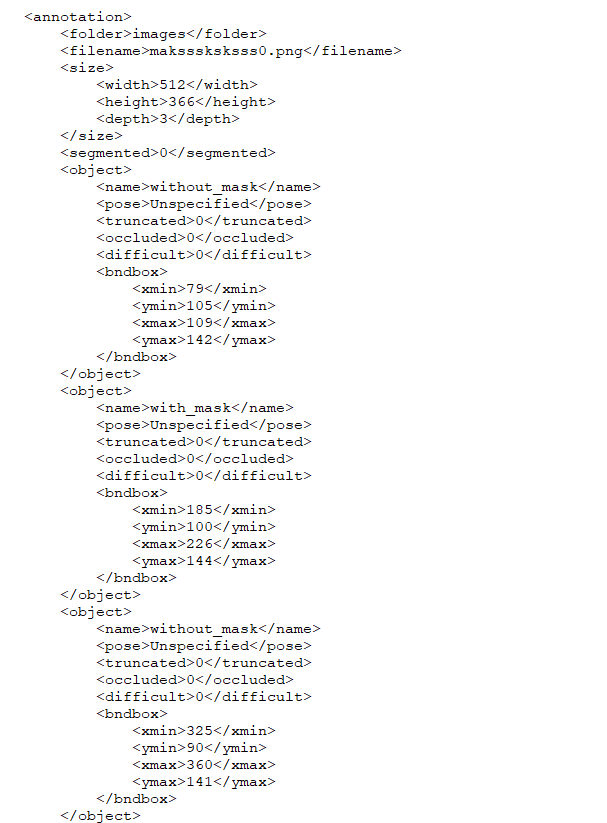

<font size = 4><font color = 'red'> First step is to getting the count of each label class </font></font>

In [3]:
#Getting count of each label class
labels = []

#Reading each file in directory
for file in os.listdir(annoDirectory):
    with open(os.path.join(annoDirectory, file), 'r') as f:
        data = f.read()
        
        #Converting the xml file into dictionary (Key:value) pair
        anno_dict=xmltodict.parse(data)["annotation"]
        
        #Extracting the Object key
        object_list = anno_dict["object"]
        
        #Checking if image has more then 1 <object> key
        if isinstance(object_list, list):
             for object_ in object_list:
                    #getting face boundaries
                    labels.append(object_["name"])
        else:
            object_ = object_list
            labels.append(object_["name"])

unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
print(sum(counts))

{'mask_weared_incorrect': 123, 'with_mask': 3232, 'without_mask': 717}
4072


Currently we have 4072 labels, and 3 different category of labels, <br>
<b> "with_mask" </b> : 3232 , <br>
<b> "without_mask" </b> : 717, <br>
<b> "mask_weared_incorrect" </b> : 123 <br><br> 
 
From this we can tell that our image data will be bias towards the category "with_mask" due to its large number, this will come in later where we will implement data augmentation to increase variety of data <br><br> 

<font size = 4><font color='red'> Next we will be getting the cropped face images and split it into 2 folders, and saving labels into y_train and y_test </font></font>

In [30]:
y_train = []
y_test = []
i=1
    
#Checking if folder exists, if doesnt exist then create folder
if not os.path.exists("./train_images/"):
    os.makedirs("./train_images/")
if not os.path.exists("./test_images/"):
    os.makedirs("./test_images/")
    
for file in os.listdir(annoDirectory):
    #open file for reading
    with open(os.path.join(annoDirectory, file), 'r') as f:
        data = f.read()
        
        #Converting the xml file into dictionary (Key:value) pair
        ann_dict=xmltodict.parse(data)["annotation"]
        
        #Extracting the Object key
        object_list = ann_dict["object"]

        #opening image by replacing file extension name from xml -> png
        image_name = file.replace("xml","png")
        im = Image.open(imgDirectory+image_name)

        #Checking if image has more then 1 <object> key
        if isinstance(object_list, list): 
            for object_ in object_list:
            
                #getting face boundaries
                xmin = int(object_["bndbox"]["xmin"])
                xmax = int(object_["bndbox"]["xmax"])
                ymin = int(object_["bndbox"]["ymin"])
                ymax = int(object_["bndbox"]["ymax"])
                        
                #cropping the face in image using annonated <xmin><xmax><ymin><ymax> labels
                crop_rectangle = (xmin, ymin, xmax , ymax)
                cropped_im = im.crop(crop_rectangle)
                #Anti-aliasing is the smoothing of jagged edges in digital images by averaging the colors of the pixels at a boundary.
                resized_im = cropped_im.resize((224,224), Image.ANTIALIAS)
                        
                #this part is for sperating train set from test set, 10% of 4072 is 3664.8
                if i<=3664:
                    resized_im.save("./train_images/"+str(i)+".png")
                    y_train.append(object_["name"])
                else:
                    resized_im.save("./test_images/"+str(i-3664)+".png")
                    y_test.append(object_["name"])
                i+=1
        else:
            #same thing on images with one face in them
            object_ = object_list
            xmin = int(object_["bndbox"]["xmin"])
            xmax = int(object_["bndbox"]["xmax"])
            ymin = int(object_["bndbox"]["ymin"])
            ymax = int(object_["bndbox"]["ymax"])

            crop_rectangle = (xmin, ymin, xmax , ymax)
            cropped_im = im.crop(crop_rectangle)
            resized_im = cropped_im.resize((224, 224), Image.ANTIALIAS)
            if i<=3664:
                resized_im.save("./train_images/"+str(i)+".png")
                y_train.append(object_["name"])
            else:
                resized_im.save("./test_images/"+str(i-3664)+".png")
                y_test.append(object_["name"])

            i+=1
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

<font size = 6>Cropped images <br></font>
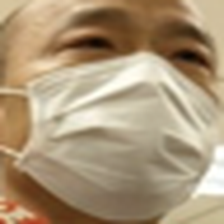 <br><br>


<font size = 4><font color ="red"> Next is to convert image into array. </font></font> 

<br><br> Converting an image to an array is an important task to train a machine learning model based on the features of an image

In [5]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [6]:
def img_to_arr(directory,num_img):
    X_nn=[]
    #Converting images to array 
    for i in range(1,num_img+1):
        img = load_img(directory+str(i)+".png")
        data = img_to_array(img)
        X_nn.append(data)
    return np.asarray(X_nn)

In [31]:
X_train = img_to_arr("./train_images/",3664)
X_test = img_to_arr("./test_images/",408)
X_train.shape

(3664, 224, 224, 3)

<font size = 4><font color ="red"> Data augmentation. </font></font> <br><br> 

Data augmentation which is to modify the data available in a realistic but randomized way to increase the variety of data seen during training. It can increase the training data complexity or size to reduce the variance. Data preparation has always been a tedious method and the most time-consuming method. Data augmentation uses a limited dataset to generate more data increasing the number of samples. 

In [8]:
uniqueTrain, counts = np.unique(y_train, return_counts=True)
print(dict(zip(uniqueTrain, counts)))
print(sum(counts))

{'mask_weared_incorrect': 110, 'with_mask': 2879, 'without_mask': 675}
3664


We will increase sample size of "mask_weared_incorrect" and "without_mask"<br> 

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

In [10]:
def add_data_aug (directory_save_inc , directory_save_no , num_inc , num_no , X_train , y_train):
    
    #Check if file name exists
    if not os.path.exists("./"+directory_save_inc):
        os.makedirs("./"+directory_save_inc)
    if not os.path.exists("./"+directory_save_no):
        os.makedirs('./'+directory_save_no)
    
    
    #the image generator ranges.
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = "nearest"
    )
    
    #Get the images from X_train which label is "without_mask" and "mask_weared_incorrect"
    without_mask = X_train[y_train=="without_mask"]
    mask_weared_incorrect = X_train[y_train=="mask_weared_incorrect"]
    
    #creating the desired number of images
    j=0
    for batch in datagen.flow(without_mask,batch_size=1,save_to_dir=directory_save_no,save_prefix="without_mask",save_format='png'):
        j+=1
        #if j> 2204:
        if j>num_no:
            break
    j=0
    for batch in datagen.flow(mask_weared_incorrect,batch_size=1,save_to_dir=directory_save_inc,save_prefix="weared_incorrectly",save_format='png'):
        j+=1
        #if j> 2769:
        if j>num_inc:
            break
    X_nn=[]
    
    #adding newly made images to training set
    for file in os.listdir(directory_save_no):
        #converting image to array and appending it
        im = Image.open(os.path.join(directory_save_no, file))
        rgb_im = im.convert('RGB')
        im = np.asarray(rgb_im,dtype="int")
        X_nn.append(im)
        #appending labels for the image
        y_train=np.append(y_train,'without_mask')
    
    
    for file in os.listdir(directory_save_inc):
        im = Image.open(os.path.join(directory_save_inc, file))
        rgb_im = im.convert('RGB')
        im = np.asarray(rgb_im,dtype="int")
        X_nn.append(im)
        y_train = np.append(y_train,"mask_weared_incorrect")
        
    X_train_augmented = np.asarray(X_nn)
    
    X_train = np.concatenate((X_train,X_train_augmented))
    
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    
    return X_train,y_train


In [32]:
#Take some time to run
#Create data for "with_mask" and "mask_weared_incorrect" to increase sample size of data
X_train,y_train = add_data_aug ("Augmented_incorrect/" , "Augmented_without/", 2769 , 2204 , X_train , y_train)

In [33]:
print(collections.Counter(y_train))
print(y_train.shape)

Counter({'without_mask': 2880, 'with_mask': 2879, 'mask_weared_incorrect': 2878})
(8637,)


#### Performing encoding on the labels

Labels are currently in alphabet formats ("with_mask", "without_mask", mask_weared_incorrect"). These text characters will not be useful for us therefore we will be converting them into character values

In [34]:
def preproccesing(X_train,X_test,y_train,y_test):
    #nomalizing color values
    X_train = X_train / 255
    X_test = X_test / 255
    
    #categorical to numerical values for labels.
    #0 for without_mask
    #1 for mask_weared_incorrect
    #2 for with_mask
    conditions = [
                    (y_train == "without_mask"),
                    y_train == ("mask_weared_incorrect"),
                    (y_train == "with_mask")]
    choices = [0, 1, 2]
    y_train = np.select(conditions, choices)
    conditions = [
                    (y_test == "without_mask"),
                    y_test == ("mask_weared_incorrect"),
                    (y_test == "with_mask")]
    choices = [0, 1, 2]
    y_test = np.select(conditions, choices)
    return X_train,X_test,y_train,y_test

In [35]:
X_train,X_test,y_train,y_test = preproccesing(X_train,X_test,y_train,y_test)

In [36]:
collections.Counter(y_train)

Counter({2: 2879, 0: 2880, 1: 2878})

# 2) Training of Model (MobileNetV2)

In [38]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import efficientnet.keras as efn

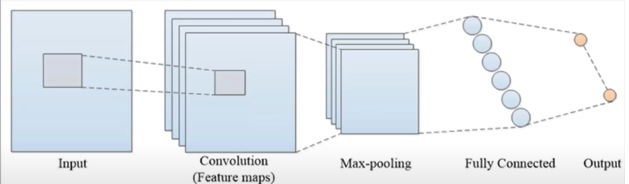<br>

For training we will be following how Convolution Neural Network (CNN) works. <br>

However, we will be ignoring how the Convolution portion for image processing and introduce MobileNet here. 

So now currently the flow is, after the image is being input as an array we will pass the image into MobileNet

By passing the image into MobileNet it will be faster in training then a CNN.

In [39]:
#There are some pre-trained model for images like imagenet, by using weights="imagenet" the weights will be initialized for us
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))
plot_model(baseModel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#taking the output of base model to create a headmodel object
headModel=baseModel.output 
#doing average pooling of 2D 7x7 matrix
headModel=AveragePooling2D(pool_size=(7,7))(headModel) 
#flattening the layers
headModel=Flatten(name='Flatten')(headModel) 
# Adding 128 dense relu, for non-linear use cases it will be the goto method
headModel=Dense(128,activation='relu')(headModel) 
#Adding droupout layers to prevent overfitting
headModel=Dropout(0.7)(headModel)
#Last dense layers for our 3 classes, we went for Softmax function as we
#are dealing with a multi-classification
headModel=Dense(3,activation='softmax')(headModel) 

model = Model(inputs=baseModel.input,outputs=headModel) 

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [40]:
#Loop over all layers in base model ans freeze them so they wont be updated
#in the first training process, because they are just a replacement for CNN
for layer in baseModel.layers:
    layer.trainable=False

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [41]:
learning_rate=0.0001
Epochs=50
BS=32

#optimizer
opt=Adam(lr=learning_rate,decay=learning_rate/Epochs)

#compiling the model, multiclass problem therefore we will be using cetegorical_crossentropy for our loss
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

C:\Users\Oliver\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [42]:
H = model.fit (
    X_train,y_train,batch_size=BS,
    steps_per_epoch=len(X_train)//BS,
    validation_data=(X_test,y_test),
    validation_steps=len(X_test)//BS,
    epochs= Epochs,
    verbose=1
)
model.save("mobilenet_model.model", save_format="h5")

Epoch 1/50
269/269 [==============================] - 78s 244ms/step - loss: 1.0271 - accuracy: 0.5170 - val_loss: 0.7530 - val_accuracy: 0.6667
Epoch 2/50
269/269 [==============================] - 65s 234ms/step - loss: 0.8012 - accuracy: 0.6371 - val_loss: 0.6017 - val_accuracy: 0.7656
Epoch 3/50
269/269 [==============================] - 63s 233ms/step - loss: 0.7073 - accuracy: 0.6933 - val_loss: 0.5745 - val_accuracy: 0.7630
Epoch 4/50
269/269 [==============================] - 63s 234ms/step - loss: 0.6421 - accuracy: 0.7321 - val_loss: 0.5405 - val_accuracy: 0.7734
Epoch 5/50
269/269 [==============================] - 62s 232ms/step - loss: 0.5987 - accuracy: 0.7482 - val_loss: 0.5860 - val_accuracy: 0.7500
Epoch 6/50
269/269 [==============================] - 63s 233ms/step - loss: 0.5604 - accuracy: 0.7657 - val_loss: 0.4365 - val_accuracy: 0.8203
Epoch 7/50
269/269 [==============================] - 62s 231ms/step - loss: 0.5349 - accuracy: 0.7793 - val_loss: 0.5260 - val_ac

C:\Users\Oliver\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


#### Confusion matrix 

In [43]:
def evaluatuion (model,X_test,y_test):
    #getting models predcitons on test set
    y_pred = []
    y_prob = model.predict(X_test)
    for i in y_prob:
        y_pred.append(np.argmax(i))
        
    confusion_matrix_array = confusion_matrix(y_test,y_pred)
    print("Confusion matrix")
    print(confusion_matrix_array)
    print("Report:")
    print(classification_report(y_test, y_pred, target_names = ["without mask","mask weared incorrectly","with mask"]))
    print("Confusion Matrix:")
    confusion_matrix_array = confusion_matrix(y_test,y_pred)
        

    g= sns.heatmap(confusion_matrix_array, annot=True,yticklabels=["Act No Mask","Act mask weared incorrectly","Act with mask"],xticklabels=["Pred No Mask","Pred mask weared incorrectly","Pred with mask"])
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    
    return y_pred

Confusion matrix
[[ 38   1   3]
 [  0  10   3]
 [ 20  15 318]]
Report:
                         precision    recall  f1-score   support

           without mask       0.66      0.90      0.76        42
mask weared incorrectly       0.38      0.77      0.51        13
              with mask       0.98      0.90      0.94       353

               accuracy                           0.90       408
              macro avg       0.67      0.86      0.74       408
           weighted avg       0.93      0.90      0.91       408

Confusion Matrix:


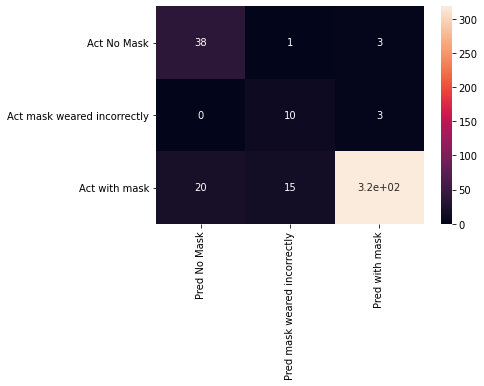

In [45]:
model=load_model("mobilenet_model.model")
y_pred = evaluatuion (model,X_test,y_test,)

#### Plotting model training and val accuracy

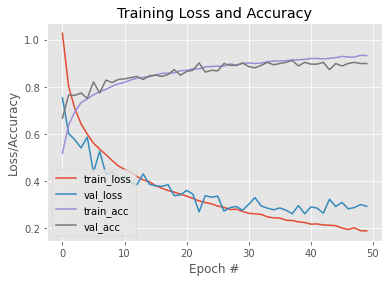

In [46]:
N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('mobilenetv2.png')

# 2b) Training of model (EfficientNetB7)

In [47]:
base_model = efn.EfficientNetB7(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
print(base_model.summary())

Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
____________________________________________________________________________________

block6k_dwconv (DepthwiseConv2D (None, 7, 7, 2304)   57600       block6k_expand_activation[0][0]  
__________________________________________________________________________________________________
block6k_bn (BatchNormalization) (None, 7, 7, 2304)   9216        block6k_dwconv[0][0]             
__________________________________________________________________________________________________
block6k_activation (Activation) (None, 7, 7, 2304)   0           block6k_bn[0][0]                 
__________________________________________________________________________________________________
block6k_se_squeeze (GlobalAvera (None, 2304)         0           block6k_activation[0][0]         
__________________________________________________________________________________________________
block6k_se_reshape (Reshape)    (None, 1, 1, 2304)   0           block6k_se_squeeze[0][0]         
__________________________________________________________________________________________________
block6k_se

In [48]:
for layer in base_model.layers:
    layer.trainable = False

In [49]:
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(3, activation="softmax")(x)
model_final = Model(inputs = base_model.input, outputs = x)
print(model_final.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

block7c_se_reduce (Conv2D)      (None, 1, 1, 160)    614560      block7c_se_reshape[0][0]         
__________________________________________________________________________________________________
block7c_se_expand (Conv2D)      (None, 1, 1, 3840)   618240      block7c_se_reduce[0][0]          
__________________________________________________________________________________________________
block7c_se_excite (Multiply)    (None, 7, 7, 3840)   0           block7c_activation[0][0]         
                                                                 block7c_se_expand[0][0]          
__________________________________________________________________________________________________
block7c_project_conv (Conv2D)   (None, 7, 7, 640)    2457600     block7c_se_excite[0][0]          
__________________________________________________________________________________________________
block7c_project_bn (BatchNormal (None, 7, 7, 640)    2560        block7c_project_conv[0][0]       
__________

In [51]:
learning_rate=0.0001
Epochs=25
BS=32

opt=Adam(lr=learning_rate,decay=learning_rate/Epochs)

#compiling the model
model_final.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [52]:
H=model_final.fit (
    X_train,y_train,batch_size=BS,
    steps_per_epoch=len(X_train)//BS,
    validation_data=(X_test,y_test),
    validation_steps=len(X_test)//BS,
    epochs= Epochs,
    #See training progress
    verbose=1
)
model_final.save("efficientnet_mask_detector.model", save_format="h5")

Epoch 1/25
269/269 [==============================] - 142s 414ms/step - loss: 0.8360 - accuracy: 0.7092 - val_loss: 0.3418 - val_accuracy: 0.8724
Epoch 2/25
269/269 [==============================] - 105s 386ms/step - loss: 0.5701 - accuracy: 0.8010 - val_loss: 0.3108 - val_accuracy: 0.8880
Epoch 3/25
269/269 [==============================] - 104s 386ms/step - loss: 0.5169 - accuracy: 0.8304 - val_loss: 0.2756 - val_accuracy: 0.9062
Epoch 4/25
269/269 [==============================] - 104s 386ms/step - loss: 0.4438 - accuracy: 0.8373 - val_loss: 0.2508 - val_accuracy: 0.9089
Epoch 5/25
269/269 [==============================] - 104s 386ms/step - loss: 0.3896 - accuracy: 0.8552 - val_loss: 0.3399 - val_accuracy: 0.8802
Epoch 6/25
269/269 [==============================] - 104s 386ms/step - loss: 0.4094 - accuracy: 0.8598 - val_loss: 0.2898 - val_accuracy: 0.8854
Epoch 7/25
269/269 [==============================] - 104s 388ms/step - loss: 0.3948 - accuracy: 0.8644 - val_loss: 0.3549 -

C:\Users\Oliver\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Confusion matrix
[[ 39   1   2]
 [  1   9   3]
 [  7  20 326]]
Report:
                         precision    recall  f1-score   support

           without mask       0.83      0.93      0.88        42
mask weared incorrectly       0.30      0.69      0.42        13
              with mask       0.98      0.92      0.95       353

               accuracy                           0.92       408
              macro avg       0.70      0.85      0.75       408
           weighted avg       0.95      0.92      0.93       408

Confusion Matrix:


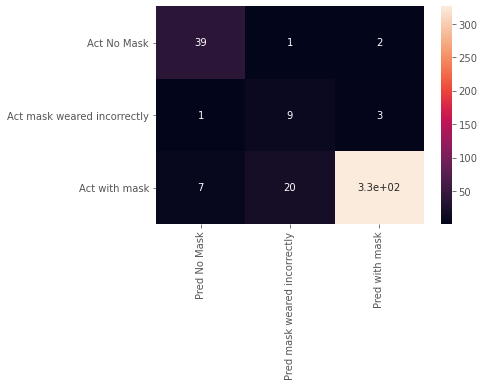

In [53]:
model_final=load_model("efficientnet_mask_detector.model")
y_pred = evaluatuion(model_final,X_test,y_test,)

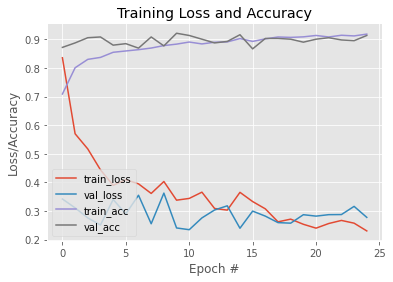

In [54]:
N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('EfficientNetB7.png')

# 3) Testing the model with Webcam

2 models will be used, face detector model to detect the face and mask detector will be used to detect mask <br><br>

In [1]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import FPS 
from imutils.video import VideoStream
import matplotlib.pyplot as plt
import numpy as np
import imutils
import time
import cv2
import os

def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h,w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame,1.0,(224,224), (104.0, 177.0, 123.0))
    
    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    
    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []
    
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0,0,i,2]
        
        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0,0,i,3:7] * np.array([w,h,w,h])
            (startX, startY, endX, endY) = box.astype("int")
            
            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w-1,endX), min(h-1,endY))
            
            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face,(224,224))
            face = img_to_array(face)
            face = preprocess_input(face)
            
            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX,endY))
    
    # only make a predictions if at least one face was detected
    if len(faces)> 0:
        # for faster inference we'll make batch predictions on *all* faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        start_time = time.time()
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size = 32)
        elapsed_time = time.time() - start_time
        print('inference time cost: {}'.format(elapsed_time))
        
    # location is the xy coordinates of the faces
    return (locs,preds)

In [61]:
#loading face detector model
prototxtPath = r"face_detector\deploy.prototxt"
weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the mask detector model
maskNet = load_model("mobilenet_model.model")

# initialize the video stream
vs = VideoStream(src=0).start()

#Video writer
videoWriter = cv2.VideoWriter('mobilenet_model.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (680 , 400), True)

#Fps counter
prev_frame_time = 0
new_frame_time = 0

# loop over the frames from the video stream
while True:
    #grab the frame from the threaded video stream and resize it
    # to have a max width of 400 pixels
    frame = vs.read()
    frame = imutils.resize(frame, width = 400)
    new_frame_time = time.time()
    #detect faces in the frame and determine if they are wearing a face mask anot
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
    
    
    # loop over the detected face locations and their corresponding location
    for (box, pred) in zip(locs, preds):
        (startX, startY, endX, endY) = box
        (mask, incorrectMask, withoutMask) = pred
        
        if withoutMask > mask and withoutMask > incorrectMask:
            label = "Mask"
            #BGR format
            color = (0,255,0)
        elif incorrectMask > withoutMask and incorrectMask > mask:
            label = "Incorrect Mask"
            color = (50,100,100)
        else:
            label = "Without Mask"
            color = (0, 0, 255)
        
        label = "{}: {:.2f}%".format(label, max(mask, incorrectMask, withoutMask)* 100)
        cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_DUPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color,2)
    
    # fps will be number of frame processed in given time frame since their will be most of time error of 0.001 second
    # we will be subtracting it to get more accurate result
    fps = 1/(new_frame_time-prev_frame_time)
    prev_frame_time = new_frame_time
    fps = int(fps)
    fps = str(fps)
  
    cv2.putText(frame, "FPS:" + fps, (7, 20), cv2.FONT_HERSHEY_DUPLEX , 0.75, (0, 255, 0), 3, cv2.LINE_AA)
    cv2.imshow("Frame",frame)
    frame = cv2.resize(frame, (680,400))
    videoWriter.write(frame)

    # wait 1ms for ESC to be pressed
    key = cv2.waitKey(1)
    if (key == 27):
        break
vs.stop()
videoWriter.release()
cv2.destroyAllWindows()

inference time cost: 0.9901373386383057
inference time cost: 0.0630958080291748
inference time cost: 0.06480002403259277
inference time cost: 0.06297183036804199
inference time cost: 0.05832242965698242
inference time cost: 0.0612339973449707
inference time cost: 0.06183481216430664
inference time cost: 0.059262990951538086
inference time cost: 0.058812618255615234
inference time cost: 0.06183600425720215
inference time cost: 0.05881619453430176
inference time cost: 0.06379890441894531
inference time cost: 0.06689572334289551
inference time cost: 0.06382894515991211
inference time cost: 0.06080913543701172
inference time cost: 0.06291460990905762
inference time cost: 0.0668184757232666
inference time cost: 0.06482577323913574
inference time cost: 0.06779074668884277
inference time cost: 0.05881309509277344
inference time cost: 0.05983996391296387
inference time cost: 0.06080961227416992
inference time cost: 0.06286048889160156
inference time cost: 0.05780839920043945
inference time cos

inference time cost: 0.06537079811096191
inference time cost: 0.06285858154296875
inference time cost: 0.06385684013366699
inference time cost: 0.059808969497680664
inference time cost: 0.06180691719055176
inference time cost: 0.06380105018615723
inference time cost: 0.06346988677978516
inference time cost: 0.06679058074951172
inference time cost: 0.06456160545349121
inference time cost: 0.06383109092712402
inference time cost: 0.06733298301696777
inference time cost: 0.05781722068786621
inference time cost: 0.05895495414733887
inference time cost: 0.062384605407714844
inference time cost: 0.05761218070983887
inference time cost: 0.05859494209289551
inference time cost: 0.06007099151611328
inference time cost: 0.06183362007141113
inference time cost: 0.06479787826538086
inference time cost: 0.06382966041564941
inference time cost: 0.06657981872558594
inference time cost: 0.06314492225646973
inference time cost: 0.0631101131439209
inference time cost: 0.0623621940612793
inference time c